In [4]:
import cv2
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import LabelEncoder
import random
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import efficientnet
from tensorflow.keras.optimizers import SGD, Adam, RMSprop

IMG_SIZE = 240
BATCH_SIZE = 32

In [2]:
!nvidia-smi

Thu Dec 22 14:28:23 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
dir = "../input/state-farm-distracted-driver-detection"
train_dir = os.path.join(dir , 'imgs/train/')
data = pd.read_csv(os.path.join(dir , 'driver_imgs_list.csv'))
data

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg
...,...,...,...
22419,p081,c9,img_56936.jpg
22420,p081,c9,img_46218.jpg
22421,p081,c9,img_25946.jpg
22422,p081,c9,img_67850.jpg


In [6]:
train_gen = ImageDataGenerator(rotation_range=40, 
                               shear_range = 0.2,
                               zoom_range = 0.2,
                               horizontal_flip = True,                               
#                                rescale = 1.0/255,                               
                               validation_split = 0.2)

train_data = train_gen.flow_from_directory(train_dir,
                                         target_size = (IMG_SIZE, IMG_SIZE),
                                         batch_size = BATCH_SIZE,
                                         color_mode ="rgb",
                                         subset='training',
                                         seed = 123)

val_data = train_gen.flow_from_directory(train_dir,
                                         target_size = (IMG_SIZE, IMG_SIZE),
                                         batch_size = BATCH_SIZE,
                                         color_mode ="rgb",
                                         subset='validation',
                                         seed = 123)

Found 17943 images belonging to 10 classes.
Found 4481 images belonging to 10 classes.


In [7]:
print(len(train_data))
print(len(val_data))

561
141


In [8]:
train_data.class_indices

{'c0': 0,
 'c1': 1,
 'c2': 2,
 'c3': 3,
 'c4': 4,
 'c5': 5,
 'c6': 6,
 'c7': 7,
 'c8': 8,
 'c9': 9}

In [ ]:
# c0: safe driving
# c1: texting - right
# c2: talking on the phone - right
# c3: texting - left
# c4: talking on the phone - left
# c5: operating the radio
# c6: drinking
# c7: reaching behind
# c8: hair and makeup
# c9: talking to passenger

[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
(240, 240, 3)


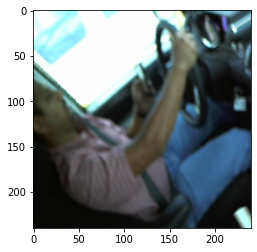

In [20]:
images, labels  = next(train_data)

print(labels[0])
print(images[0].shape)

plt.imshow(images[0])

In [9]:
from tensorflow.keras.applications import EfficientNetB0

model_base = EfficientNetB0(include_top=False,
                weights="imagenet",
                input_shape=(IMG_SIZE, IMG_SIZE, 3))

model_base.trainable = False
# model_base.summary()

2022-12-22 14:29:38.351236: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-22 14:29:38.450470: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-22 14:29:38.451272: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-22 14:29:38.452765: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

16719872/16705208 [==============================] - 0s 0us/step


In [10]:
from tensorflow import keras

inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

m = model_base(inputs, training=False)

m = keras.layers.GlobalAveragePooling2D()(m)                       ## convert the last feature map into a feature vector
m = keras.layers.BatchNormalization()(m)
m = keras.layers.Dense(512, activation='relu')(m)
m = keras.layers.Dropout(0.2)(m)
outputs = keras.layers.Dense(10, activation='softmax')(m)           ##  add output layer 

model = keras.Model(inputs, outputs)                               ## connect input and output   
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 240, 240, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, 8, 8, 1280)        4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1280)              5120      
_________________________________________________________________
dense (Dense)                (None, 512)               655872    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                5130  

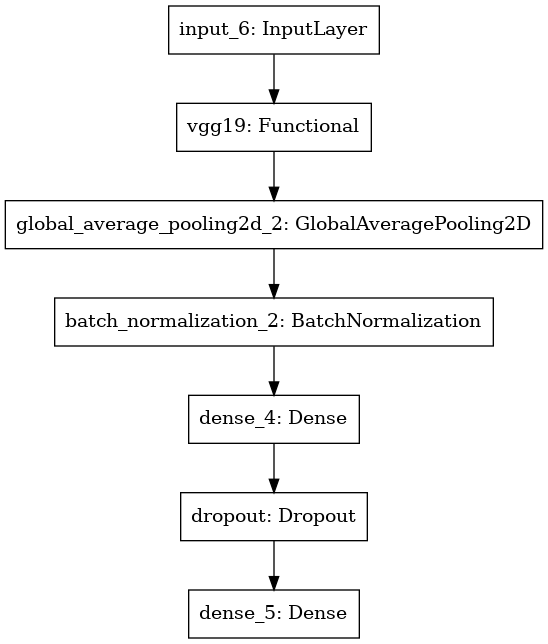

In [33]:
plot_model(model)

In [12]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

ck = ModelCheckpoint(    
    filepath= 'model-{epoch:03d}-{val_loss:03f}.hdf5',    
    monitor='val_loss',
    mode='min',
    save_best_only=True)

es = EarlyStopping(monitor = 'val_loss', patience = 10)

In [14]:
from tensorflow.keras.optimizers import SGD, Adam, RMSprop

model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

2022-12-22 14:30:19.205056: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/15


2022-12-22 14:30:25.590714: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


561/561 [==============================] - 529s 924ms/step - loss: 0.6710 - accuracy: 0.7862 - val_loss: 0.2708 - val_accuracy: 0.9148


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/15
561/561 [==============================] - 371s 661ms/step - loss: 0.3191 - accuracy: 0.8999 - val_loss: 0.2251 - val_accuracy: 0.9277
Epoch 3/15
561/561 [==============================] - 372s 664ms/step - loss: 0.2738 - accuracy: 0.9102 - val_loss: 0.1496 - val_accuracy: 0.9500
Epoch 4/15
561/561 [==============================] - 370s 660ms/step - loss: 0.2309 - accuracy: 0.9256 - val_loss: 0.1536 - val_accuracy: 0.9505
Epoch 5/15
561/561 [==============================] - 373s 665ms/step - loss: 0.2007 - accuracy: 0.9356 - val_loss: 0.1339 - val_accuracy: 0.9567
Epoch 6/15
561/561 [==============================] - 375s 668ms/step - loss: 0.1724 - accuracy: 0.9427 - val_loss: 0.1180 - val_accuracy: 0.9650
Epoch 7/15
561/561 [==============================] - 375s 669ms/step - loss: 0.1652 - accuracy: 0.9473 - val_loss: 0.1200 - val_accuracy: 0.9645
Epoch 8/15
561/561 [==============================] - 374s 667ms/step - loss: 0.1442 - accuracy: 0.9549 - val_loss: 0.1084 -

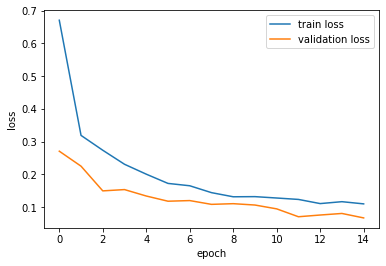

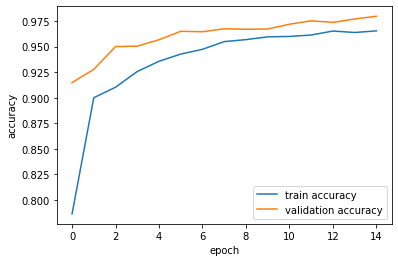

In [15]:
# hist = model.fit(X_train, Y_train, validation_split = 0.2, epochs=10, callbacks=[ck])
hist = model.fit(tr
                 ain_data, shuffle=True, validation_data = val_data, epochs=15, callbacks=[ck,es])

plt.plot(hist.history['loss'])                                               ## plot loss curve during training 
plt.plot(hist.history['val_loss'])
plt.legend(['train loss','validation loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

plt.plot(hist.history['accuracy'])                                               ## plot accuracy curve during training 
plt.plot(hist.history['val_accuracy'])
plt.legend(['train accuracy','validation accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

In [10]:
model.save('best_model.h5')

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [11]:
from tensorflow import keras
model_load = keras.models.load_model('/kaggle/working/best_model.h5')

In [16]:
dir = "../input/state-farm-distracted-driver-detection"
test_dir = os.path.join(dir , 'imgs')
test_gen = ImageDataGenerator()

test_data = test_gen.flow_from_directory(test_dir ,
                                        target_size=(IMG_SIZE, IMG_SIZE),
                                        batch_size=BATCH_SIZE,
                                        classes = ['test'],
                                        shuffle = False)

Found 79726 images belonging to 1 classes.


In [21]:
score = model.evaluate(test_data)
print(score[1]*100.0)

1994/1994 [==============================] - 804s 403ms/step - loss: 112.1364 - accuracy: 0.0870
8.69603380560875


In [17]:
preds = model.predict(test_data)
preds

array([[8.0578033e-09, 1.6512208e-11, 6.3221393e-11, ..., 1.9504927e-07,
        7.7504454e-05, 3.4132545e-04],
       [9.9991846e-01, 5.1271465e-10, 3.3430812e-14, ..., 1.2607619e-12,
        8.2639372e-07, 1.7239831e-09],
       [9.9125296e-01, 2.9541489e-03, 1.7663493e-06, ..., 9.8729270e-06,
        3.7500130e-03, 1.1609313e-03],
       ...,
       [1.4428474e-04, 5.9663430e-03, 5.0042565e-10, ..., 1.2795550e-05,
        4.9521253e-03, 2.6568695e-04],
       [1.9477432e-11, 2.2356579e-07, 1.4620267e-01, ..., 1.3991489e-12,
        1.5448713e-02, 1.5802057e-08],
       [4.5436928e-01, 1.7503343e-03, 1.4588094e-09, ..., 3.9310452e-10,
        5.4202919e-06, 1.4482451e-07]], dtype=float32)

In [18]:
print(len(preds))

79726


In [19]:
import pandas as pd

test_imgs = os.path.join(dir , 'imgs/test')
test_ids = sorted(os.listdir(test_imgs))
pred_df = pd.DataFrame(columns=['img','c0','c1','c2','c3','c4','c5','c6','c7','c8','c9'])
for i in range(len(preds)):
    pred_df.loc[i,'img'] = test_ids[i]
    pred_df.loc[i , 'c0':'c9'] = preds[i]

In [20]:
pred_df

,img,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9
0,img_1.jpg,0.0,0.0,0.0,0.0,0.0,0.999581,0.0,0.0,0.000078,0.000341
1,img_10.jpg,0.999918,0.0,0.0,0.000053,0.000025,0.000002,0.0,0.0,0.000001,0.0
2,img_100.jpg,0.991253,0.002954,0.000002,0.0,0.0,0.0,0.00087,0.00001,0.00375,0.001161
3,img_1000.jpg,0.0,0.0,0.004176,0.0,0.0,0.0,0.000002,0.0,0.799006,0.196817
4,img_100000.jpg,0.000031,0.0,0.0,0.999967,0.000001,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
79721,img_99994.jpg,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
79722,img_99995.jpg,0.017373,0.000118,0.0,0.900678,0.015966,0.001306,0.000006,0.000157,0.000038,0.064358
79723,img_99996.jpg,0.000144,0.005966,0.0,0.074368,0.914011,0.000115,0.000165,0.000013,0.004952,0.000266
79724,img_99998.jpg,0.0,0.0,0.146203,0.0,0.0,0.0,0.838348,0.0,0.015449,0.0


In [21]:
pred_df.to_csv('submission.csv',index = False)